<a href="https://www.kaggle.com/code/samithsachidanandan/time-series-forecasting-with-xgboost?scriptVersionId=300268117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')


In [2]:
df =pd.read_csv('/kaggle/input/german-power-consumption/power_consumption_germany.csv')

In [3]:
df.head()

,Unnamed: 0,load_Actual Load,wind_and_solar_forecast_Solar,wind_and_solar_forecast_Wind Offshore,wind_and_solar_forecast_Wind Onshore,intraday_wind_and_solar_forecast_Solar,intraday_wind_and_solar_forecast_Wind Offshore,intraday_wind_and_solar_forecast_Wind Onshore,generation_Biomass_Actual Aggregated,generation_Biomass_Actual Consumption,...,generation_import_Import_PL,generation_import_Import_SE_4,generation_import_Import_SI,generation_import_Import_sum,import_BE,generation_import_Import_BE,import_AT,generation_import_Import_AT,import_NO_2,generation_import_Import_NO_2
0,2015-01-01 00:00:00+01:00,51873.64,0.0,258.0,7517.70,0.0,219.0,3713.0,5014.84,0.0,...,NaN,0.0,0.0,3001.04,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:15:00+01:00,51382.96,0.0,258.0,7603.26,0.0,219.0,3789.0,5020.28,0.0,...,NaN,0.0,0.0,3001.04,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 00:30:00+01:00,51444.18,0.0,259.0,7695.36,0.0,218.5,3866.0,5016.53,0.0,...,NaN,0.0,0.0,3001.04,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 00:45:00+01:00,51268.75,0.0,259.0,7779.20,0.0,218.5,3942.0,5006.21,0.0,...,NaN,0.0,0.0,3001.04,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 01:00:00+01:00,50869.89,0.0,259.0,8108.18,0.0,218.5,4175.5,4978.48,0.0,...,NaN,0.0,0.0,3179.07,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.rename(columns={'Unnamed: 0': 'Datetime', 'load_Actual Load': 'actual_load'}, inplace=True)

In [5]:
df = df[['Datetime','actual_load' ]]

In [6]:
df =df.set_index('Datetime')
df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')

In [7]:
df.head()

,actual_load
Datetime,
2015-01-01 00:00:00+01:00,51873.64
2015-01-01 00:15:00+01:00,51382.96
2015-01-01 00:30:00+01:00,51444.18
2015-01-01 00:45:00+01:00,51268.75
2015-01-01 01:00:00+01:00,50869.89


# Outlier Removal

In [8]:
df.shape

(380594, 1)

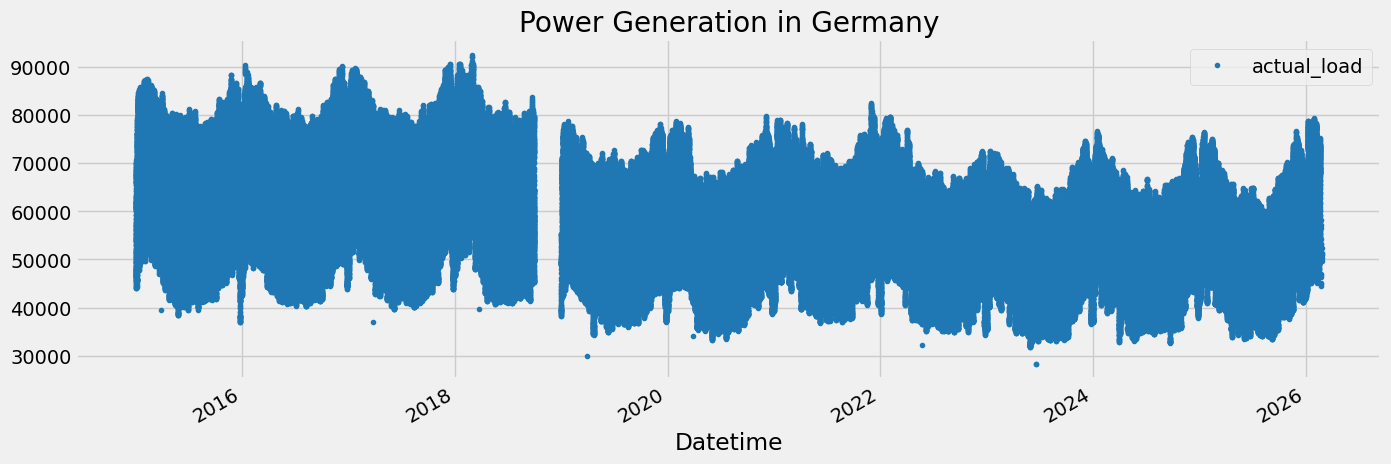

In [9]:
df.plot(style='.',
       figsize=(15,5),
    color=color_pal[0],
    title= 'Power Generation in Germany')

plt.show()

In [10]:
df= df[df.index.year>2019]

In [11]:
df.shape

(214506, 1)

<Axes: ylabel='Frequency'>

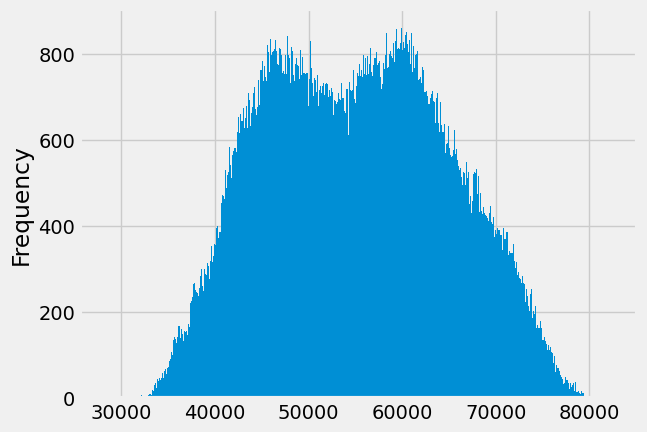

In [12]:
df['actual_load'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

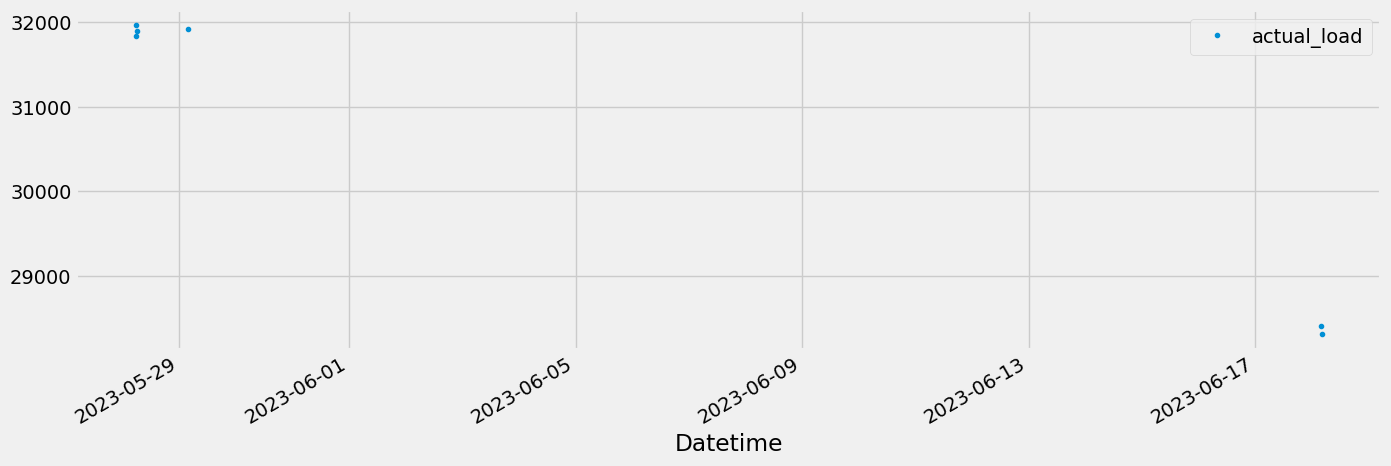

In [13]:
df.query('actual_load<32_000').plot(figsize=(15,5), style='.')

In [14]:
df = df.query('actual_load>32_000').copy()

# Train - test split 

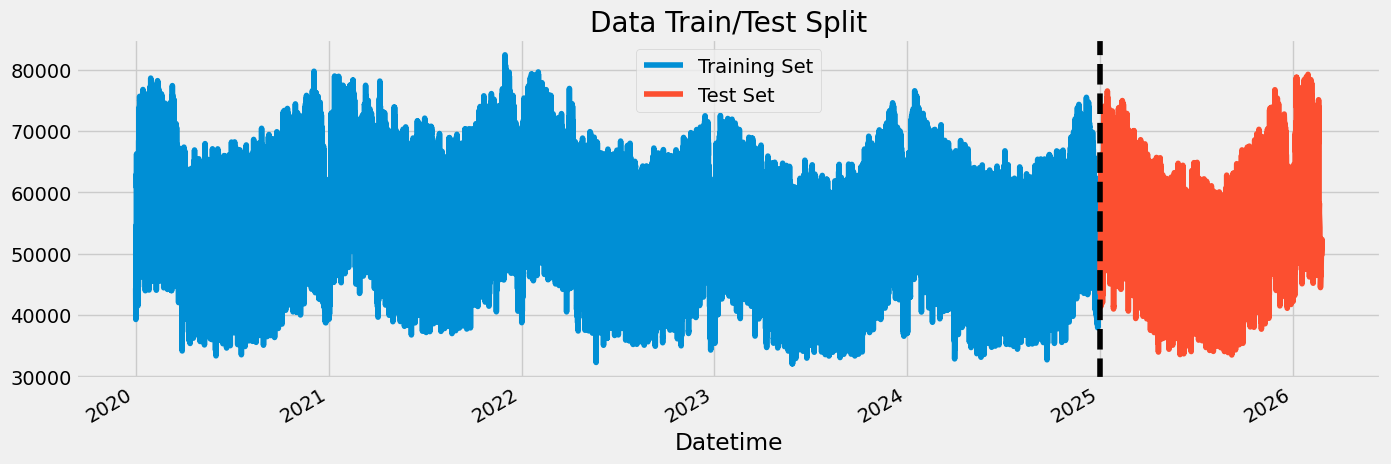

In [15]:
train = df.loc[df.index < '2025-01-01']
test = df.loc[df.index >= '2025-01-01']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('2025-01-01',color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Time Series Corss Validation 

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

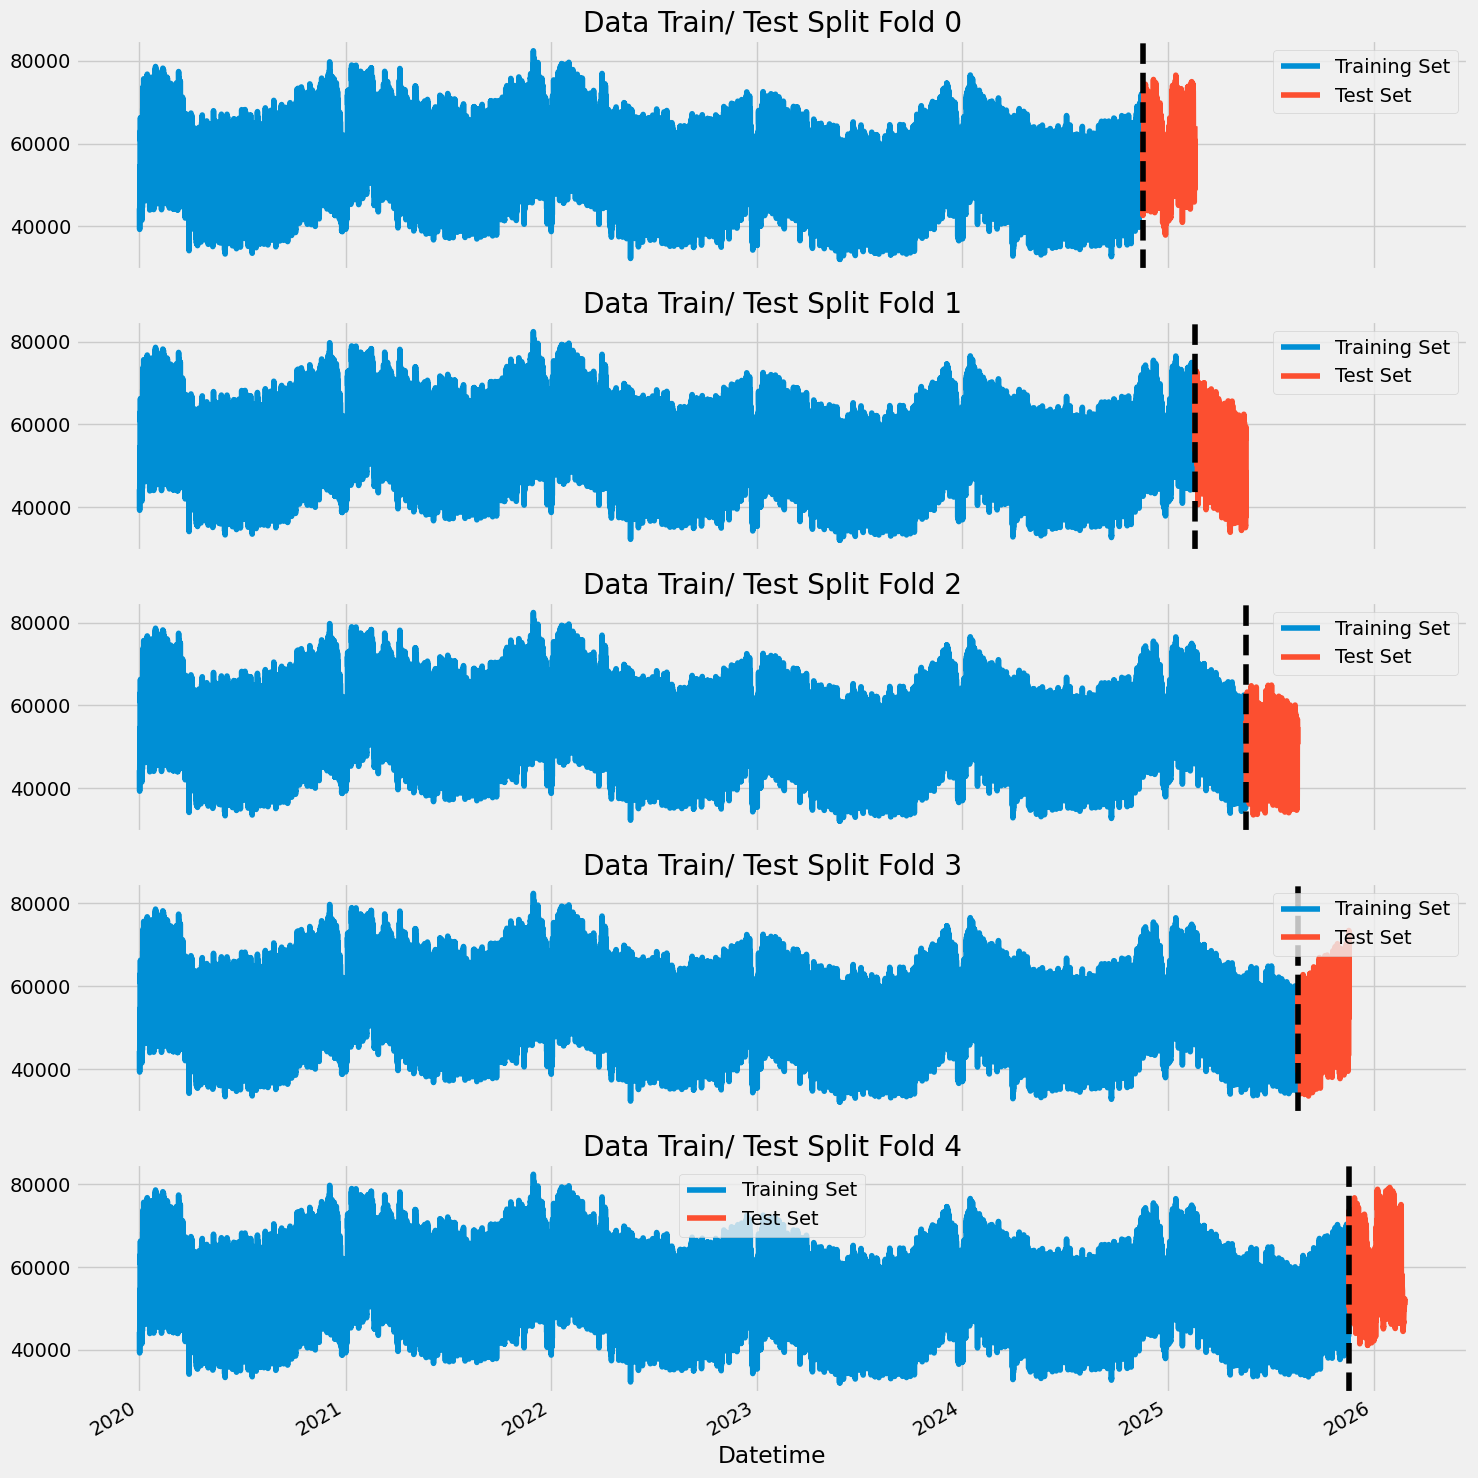

In [17]:

fig, axs = plt.subplots(5,1, figsize=(15,15),sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train =df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['actual_load'].plot(ax=axs[fold],label='Training Set', title=f'Data Train/ Test Split Fold {fold}')

    test['actual_load'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.tight_layout()
plt.show()

    

# Feature Engineering

In [18]:
def feature_enginer(df):
    df = df.copy()
    df['hour'] =df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

df = feature_enginer(df)

In [19]:
def add_lags(df):

    target_map = df['actual_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df 

In [20]:
df = add_lags(df)

In [21]:
df.tail()

,actual_load,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2026-02-24 00:15:00+01:00,50272.859150,0,1,1,2,2026,55,24,9,49884.619,48682.18,49676.19
2026-02-24 00:30:00+01:00,49671.233480,0,1,1,2,2026,55,24,9,49173.414,48924.09,48711.66
2026-02-25 00:00:00+01:00,52329.732770,0,2,1,2,2026,56,25,9,49326.060,50294.90,50066.23
2026-02-25 00:15:00+01:00,51366.956040,0,2,1,2,2026,56,25,9,49526.217,49587.82,49647.57
2026-02-25 00:30:00+01:00,50836.986899,0,2,1,2,2026,56,25,9,49194.011,49663.79,49374.66


# Training using Cross Validation 

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []


for train_idx, val_idx in tss.split(df):
    train =df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = feature_enginer(train)
    test = feature_enginer(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
               'lag1', 'lag2', 'lag3']
    TARGET = 'actual_load'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg =xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train),(X_test, y_test)],
           verbose=100)

    y_pred =reg.predict(X_test)
    preds.append(y_pred)
    score =np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    

[0]	validation_0-rmse:55473.25294	validation_1-rmse:59062.72272
[100]	validation_0-rmse:20829.05446	validation_1-rmse:24089.52978
[200]	validation_0-rmse:8596.27930	validation_1-rmse:11272.34169
[300]	validation_0-rmse:4687.31805	validation_1-rmse:6646.38925
[400]	validation_0-rmse:3635.44880	validation_1-rmse:4974.88670
[500]	validation_0-rmse:3319.72433	validation_1-rmse:4336.88612
[600]	validation_0-rmse:3185.52436	validation_1-rmse:4046.57417
[700]	validation_0-rmse:3104.28594	validation_1-rmse:3910.90074
[800]	validation_0-rmse:3035.23386	validation_1-rmse:3754.40318
[900]	validation_0-rmse:2963.31393	validation_1-rmse:3646.50268
[999]	validation_0-rmse:2888.48779	validation_1-rmse:3556.01856
[0]	validation_0-rmse:55652.01397	validation_1-rmse:53294.26087
[100]	validation_0-rmse:20891.65310	validation_1-rmse:19907.89864
[200]	validation_0-rmse:8621.18961	validation_1-rmse:8171.08283
[300]	validation_0-rmse:4708.89813	validation_1-rmse:4485.38406
[400]	validation_0-rmse:3658.69402	

In [23]:
print(f'Scores across folds {np.mean(scores):0.4f}')
print(f"Fold Scores: {scores}")

Scores across folds 3305.2236
Fold Scores: [np.float64(3556.0185688491024), np.float64(3378.469061007619), np.float64(2683.346468634639), np.float64(3164.1447773814157), np.float64(3744.1393202954555)]


In [24]:
df = feature_enginer(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
               'lag1', 'lag2', 'lag3']
TARGET = 'actual_load'


X = df[FEATURES]
y = df[TARGET]


reg =xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                     n_estimators=1000,
                     early_stopping_rounds=50,
                     objective='reg:linear',
                     max_depth=3,
                     learning_rate=0.01)
reg.fit(X, y,
       eval_set=[(X, y)],
       verbose=100)


[0]	validation_0-rmse:55440.66040
[100]	validation_0-rmse:20795.39790
[200]	validation_0-rmse:8576.96609
[300]	validation_0-rmse:4702.27773
[400]	validation_0-rmse:3662.93709
[500]	validation_0-rmse:3359.68451
[600]	validation_0-rmse:3216.39593
[700]	validation_0-rmse:3123.10327
[800]	validation_0-rmse:3050.60637
[900]	validation_0-rmse:2990.31685
[999]	validation_0-rmse:2936.98594


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
df.index.max()

Timestamp('2026-02-25 00:30:00+0100', tz='Europe/Berlin')

In [26]:
future = pd.date_range(start='2026-02-24',end='2027-02-24',freq='1h',tz='Europe/Berlin')
future_df = pd.DataFrame(index=future)
future_df['IsFuture'] = True
df['IsFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = feature_enginer(df_and_future)
df_and_future = add_lags(df_and_future)


In [27]:
future_w_features = df_and_future.query('IsFuture').copy()

In [28]:
future_w_features

,actual_load,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,IsFuture
2026-02-24 00:00:00+01:00,NaN,0,1,1,2,2026,55,24,9,50324.043,49109.970,50365.52,True
2026-02-24 01:00:00+01:00,NaN,1,1,1,2,2026,55,24,9,48149.914,48079.920,47929.44,True
2026-02-24 02:00:00+01:00,NaN,2,1,1,2,2026,55,24,9,46891.754,46938.200,47233.73,True
2026-02-24 03:00:00+01:00,NaN,3,1,1,2,2026,55,24,9,46885.781,46981.730,47481.07,True
2026-02-24 04:00:00+01:00,NaN,4,1,1,2,2026,55,24,9,47644.463,48149.440,48464.34,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-02-23 20:00:00+01:00,NaN,20,1,1,2,2027,54,23,8,NaN,63235.919,64340.89,True
2027-02-23 21:00:00+01:00,NaN,21,1,1,2,2027,54,23,8,NaN,59857.788,60909.62,True
2027-02-23 22:00:00+01:00,NaN,22,1,1,2,2027,54,23,8,NaN,56384.164,57345.05,True
2027-02-23 23:00:00+01:00,NaN,23,1,1,2,2027,54,23,8,NaN,52769.807,53854.29,True


# Predict the future

In [29]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

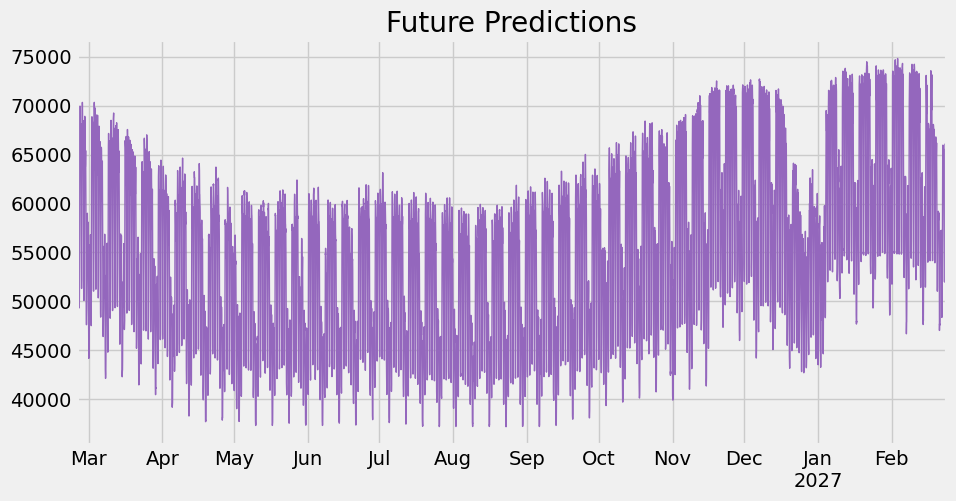

In [30]:
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[4],ms=1, lw=1, title='Future Predictions')
plt.show()

# Saving the Model 

In [31]:
reg.save_model('model.json')